In [8]:
#take in X_train, filter only for relevant columns
import pandas as pd
import numpy as np
df = pd.read_pickle('credit_card_df.pkl')
model_df = df[['pay_0', 'pay_2', 'max_bill_to_cred_lim', 'adjusted_bill_var',
       'Total_Pay_Amt', 'avg_bill_amt', 'adjusted_pay_variance', 'age',
       'paid_limit_ratio', 'default_payment']]

#'pay_2',

In [9]:
model_df = model_df.apply(pd.to_numeric, errors='coerce')


In [10]:
model_df

,pay_0,pay_2,max_bill_to_cred_lim,adjusted_bill_var,Total_Pay_Amt,avg_bill_amt,adjusted_pay_variance,age,paid_limit_ratio,default_payment
0,2,2,0.195650,3.047508,689.0,1284.000000,0.536604,24,0.034450,1
1,-1,2,0.028792,0.607835,5000.0,2846.166667,0.702700,26,0.041667,1
2,0,0,0.324878,0.925501,11018.0,16942.166667,0.236097,34,0.122422,0
3,0,0,0.985820,0.544070,8388.0,38555.666667,0.026429,37,0.167760,0
4,-1,0,0.716700,1.655311,59049.0,18223.166667,1.975617,57,1.180980,0
...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0.947114,1.591386,42550.0,120891.500000,0.157166,39,0.193409,0
29996,-1,-1,0.059860,2.543386,14490.0,3530.333333,2.548768,43,0.096600,0
29997,4,3,0.695933,1.542215,31300.0,11749.333333,1.872447,37,1.043333,1
29998,1,-1,0.979738,1.800916,147181.0,44435.166667,1.906643,41,1.839762,1


In [11]:
#drop null vals
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)
model_df.dropna(inplace = True)
model_df.shape

(29130, 10)

In [12]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29130 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pay_0                  29130 non-null  int64  
 1   pay_2                  29130 non-null  int64  
 2   max_bill_to_cred_lim   29130 non-null  float64
 3   adjusted_bill_var      29130 non-null  float64
 4   Total_Pay_Amt          29130 non-null  float64
 5   avg_bill_amt           29130 non-null  float64
 6   adjusted_pay_variance  29130 non-null  float64
 7   age                    29130 non-null  int64  
 8   paid_limit_ratio       29130 non-null  float64
 9   default_payment        29130 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 2.4 MB


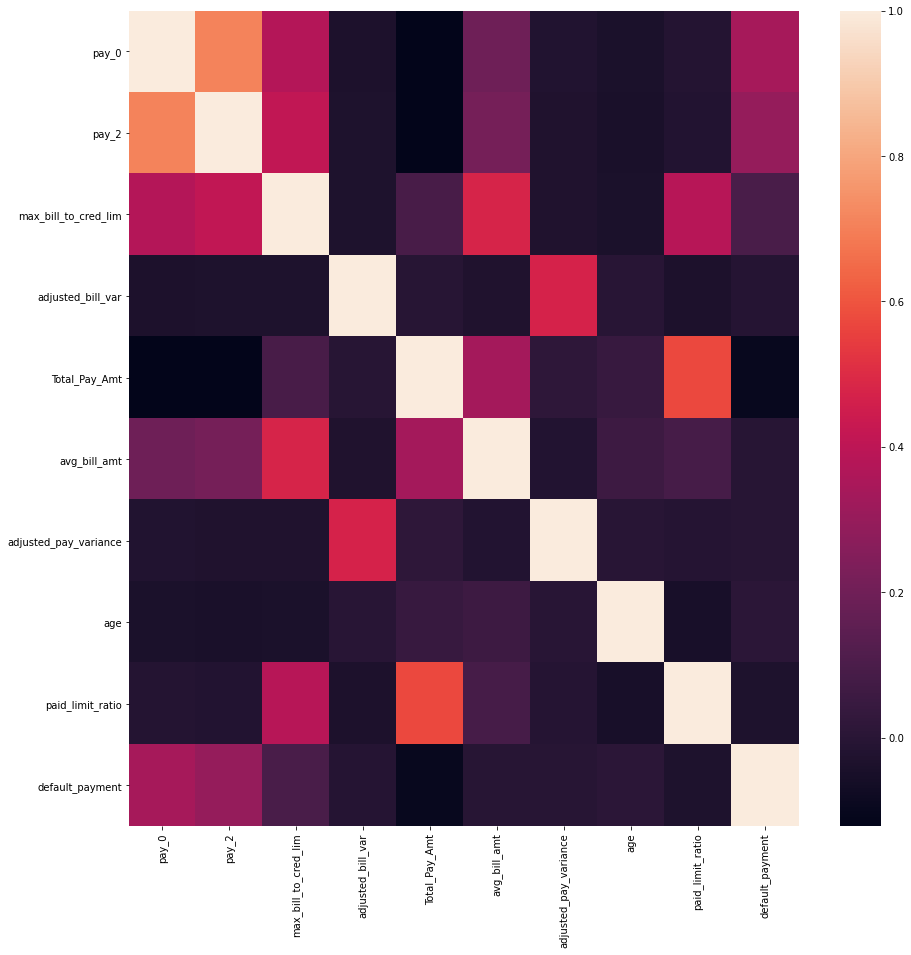

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (15,15))
sns.heatmap(model_df.corr())

In [14]:
#split
from sklearn.model_selection import train_test_split

import pickle

X, y = model_df.iloc[:,:-1], model_df['default_payment']

X_train, X_test, y_train, y_test = train_test_split(X,y)

#rebalance
from imblearn.over_sampling import RandomOverSampler
import imblearn.over_sampling
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg}
ROS = RandomOverSampler(sampling_strategy = ratio, random_state=42)    
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train, y_train)

#scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr_rs)
X_te = scaler.transform(X_test)

pickle.dump(scaler, open('scaler.pkl', 'wb'))


In [26]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [300],
    'max_depth': [10,20,30]
}

grid_search = GridSearchCV(estimator=rf,
             param_grid=param_grid, scoring = 'recall', cv = 5)

grid_search.fit(X_tr, y_tr_rs)
best_params = grid_search.best_params_
print(best_params)

{'max_depth': 30, 'n_estimators': 300}
CPU times: user 5min 50s, sys: 6.11 s, total: 5min 56s
Wall time: 6min 47s


In [27]:
#fit model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                             max_depth = best_params['max_depth'])

# rfc = RandomForestClassifier(n_estimators = 200,
#                               max_depth = 70)

rfc.fit(X_tr, y_tr_rs)



RandomForestClassifier(max_depth=30, n_estimators=300)

In [28]:
#pckage

In [29]:
y_pred = rfc.predict(X_te)
from sklearn.metrics import recall_score, accuracy_score, f1_score

print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1: ', f1_score(y_test, y_pred))

accuracy:  0.8131264588768364
recall:  0.4370651486401012
f1:  0.5038279256288735


In [30]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_tr, y_tr_rs)


LogisticRegression()

In [31]:
y_pred = lr.predict(X_te)
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 71)


print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1: ', f1_score(y_test, y_pred))
print('recall_cv_lr', np.mean(cross_val_score(lr, X_tr, y_tr_rs, cv=kf, scoring='recall')))
print('recall_cv_rfc', np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')))

accuracy:  0.8044761773994233
recall:  0.49019607843137253
f1:  0.5211835911230666
recall_cv_lr 0.486728761165719
recall_cv_rfc 0.9486817328029457


In [32]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(X_tr, y_tr_rs)

y_pred = gnb.predict(X_te)
from sklearn.metrics import recall_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 71)


print('accuracy: ', accuracy_score(y_test, y_pred))
print('recall: ', recall_score(y_test, y_pred))
print('f1: ', f1_score(y_test, y_pred))
print('recall_cv_gnb', np.mean(cross_val_score(gnb, X_tr, y_tr_rs, cv=kf, scoring='recall')))
print('recall_cv_rfc', np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')))

accuracy:  0.5559522174927914
recall:  0.7735610373181531
f1:  0.43063380281690145
recall_cv_gnb 0.6956050635916894
recall_cv_rfc 0.9482592959350582


In [33]:
# from sklearn.neighbors import KNeighborsClassifier

# knn = KNeighborsClassifier()
# param_grid = {
#     'n_neighbors':[1,2,3,4,5,6,7,8,9,10]
# }

# grid_search = GridSearchCV(estimator=knn,
#              param_grid=param_grid, scoring = 'recall', cv = 5)

# grid_search.fit(X_tr, y_tr_rs)
# best_params = grid_search.best_params_
# print(best_params)


In [34]:

# KNN = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'])
# KNN.fit(X_tr, y_tr_rs)
# y_pred = KNN.predict(X_te)



# print('accuracy: ', accuracy_score(y_test, y_pred))
# print('recall: ', recall_score(y_test, y_pred))
# print('f1: ', f1_score(y_test, y_pred))
# print('recall_cv_gnb', np.mean(cross_val_score(gnb, X_tr, y_tr_rs, cv=kf, scoring='recall')))
# print('recall_cv_rfc', np.mean(cross_val_score(rfc, X_tr, y_tr_rs, cv=kf, scoring='recall')))
# print('recall_cv_knn', np.mean(cross_val_score(KNN, X_tr, y_tr_rs, cv=kf, scoring='recall')))

In [35]:
import pickle
model = rfc
pickle.dump(model, open('pickled_model2.p', 'wb'))

In [36]:
X_tr.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
X_tr.describe()
